In [3]:
import os
import sys

top_dir = os.path.split(os.getcwd())[0]
sys.path.append(top_dir)
sys.path.append(os.path.join(top_dir, "src"))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns

%load_ext lab_black

In [50]:
def autolabel(ax, orient="h", fmt="{:,f}", xytext=(5, -4), **kwargs):
    """Automatically labels the rectangles in a (vertical) bar chart.
    """

    for rect in ax.patches:
        if orient == "h":
            size = rect.get_width()
            xy = (size, rect.get_y())
        else:
            size = rect.get_height()
            xy = (rect.get_x() + rect.get_width() / 2, size)
        if size != 0:
            ax.annotate(
                fmt.format(size),
                xy=xy,
                xytext=xytext,
                textcoords="offset points",
                ha="center",
                va="bottom",
                **kwargs,
            )


def get_colnames(genres, metric_names):
    return [f"{name}_{genre}" for name in metric_names for genre in genres]


def build_df(results, metric_names):
    genres = results[metric_names[0]].keys()
    per_metric_dfs = []
    for genre in genres:
        per_genre_dfs = []
        for metric in metric_names:
            df = pd.DataFrame(np.array(results[metric][genre]), columns=["value"])
            df["metric"] = metric
            df["model"] = genre
            per_genre_dfs.append(df)
        per_metric_dfs.append(pd.concat(per_genre_dfs, axis=0))
        
    return pd.concat(per_metric_dfs, axis=0)[["model", "metric", "value"]]

In [51]:
# Load the results
model_name = os.listdir("../results")[0]
fpath = os.path.join("../results", model_name, "C2P_results.json")

with open(fpath, "r") as f:
    results = json.load(f)

# Create dataframes
chromas = build_df(results, ["chroma_similarities"])
style_macro = build_df(results, ["macro_time_pitch_diff", "macro_onset_duration"])
style_per_song = build_df(
    results, ["per_song_time_pitch_diff", "per_song_onset_duration"]
)

nano_metrics = pd.concat([chromas, style_per_song], axis=0)

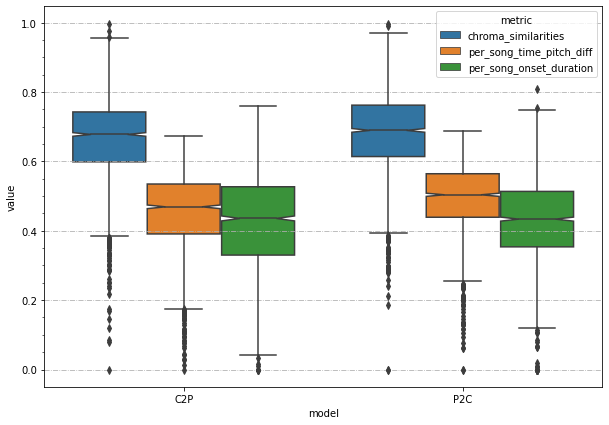

In [81]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(10, 7))

ax = sns.boxplot(
    x="model", y="value", hue="metric", data=nano_metrics, ax=ax, notch=True
)
ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.grid(True, linestyle="-.")

plt.show()

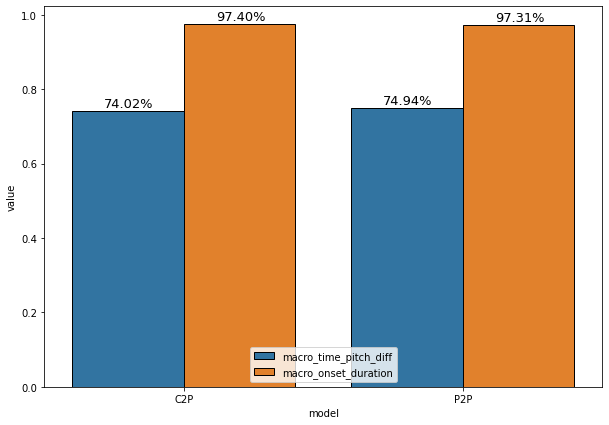

In [85]:
fig, ax = plt.subplots(figsize=(10, 7))

ax = sns.barplot(x="model", y="value", hue="metric", data=style_macro, ec="k", lw=1)
autolabel(ax, orient="v", fmt="{:.2%}", xytext=(1, 1), size=13)
ax.legend(loc="lower center")

plt.show()